In [1]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root
import importlib

import helpers
import dataset_processing
import models
import xai

torch_device = helpers.utils.get_torch_device()

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import typing as t
from pathlib import Path
import json

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [209]:
AVAILABLE_MODELS = ("ResNet50", "ConvNeXtSmall", "SwinTransformerSmall")

## Load in results

In [210]:
dfs = dict()
for explainer_name in t.get_args(xai.EXPLAINER_NAMES):
    results_for_exp = dict()
    h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / "evaluation_output.h5"
    store = pd.HDFStore(str(h5_output_path), mode="r")
    for key_name in store.keys():
        table_name = key_name.strip("/")
        df: pd.DataFrame = store[table_name]
        if df.isna().sum().sum() != 0:
            raise RuntimeError("A results table contains NaN values!")
        else:
            # adjust value in line with methodology formula
            df["output_completeness : preservation_check_conf_drop"] = 1 - df["output_completeness : preservation_check_conf_drop"]

            results_for_exp[table_name] = df
    dfs[explainer_name] = results_for_exp
    store.close()
for key in dfs.keys():
    print(f"{key}: {len(dfs[key])} tables loaded")

PartitionSHAP: 12 tables loaded
GradCAM: 12 tables loaded
KPCACAM: 12 tables loaded


### Export results to excel and make one mega tidied-up dataframe

In [211]:
ew = pd.ExcelWriter("all_results_export.xlsx")
big_df_dict = dict()
for sheet_name, df_dict in dfs.items():
    temp_df = pd.concat(df_dict).reset_index()
    temp_df["dataset"] = temp_df["level_0"].str.split("_").str.get(0)
    temp_df["model"] = temp_df["level_0"].str.split("_").str.get(1)
    temp_df = temp_df.rename(columns={"level_1": "class_label"}).set_index(["dataset", "model", "class_label"]).drop(["level_0"], axis="columns")

    temp_df.to_excel(ew, sheet_name=sheet_name, index=True, merge_cells=False)

    big_df_dict[sheet_name] = temp_df
ew.close()

#### Clean up dataframe into desired multiindex format

In [315]:
xai_ds_m_c_df = pd.concat(big_df_dict.values(), keys=big_df_dict.keys(), names=["xai_method"])
xai_ds_m_c_df = xai_ds_m_c_df.drop(
    columns=xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.startswith("continuity") | xai_ds_m_c_df.columns.str.endswith("l2_distance")]
)
xai_ds_m_c_df.columns = xai_ds_m_c_df.columns.str.replace("randomised_model_similarity", "random_sim").str.replace("adversarial_attack_similarity", "adv_attk_sim").str.replace("correctness", "COR").str.replace("output_completeness", "O-C").str.replace("contrastivity", "CON").str.replace("compactness", "COM").str.replace("spearman_rank", "SR").str.replace("top_k_intersection", "top_m").str.replace("structural_similarity", "ssim")
xai_ds_m_c_df = xai_ds_m_c_df.replace(-np.inf, np.nan)
xai_ds_m_c_df.columns, xai_ds_m_c_df.index[-1]

(Index(['COR : random_sim : SR', 'COR : random_sim : top_m',
        'COR : random_sim : ssim', 'COR : incremental_deletion_auc_ratio',
        'O-C : deletion_check_conf_drop', 'O-C : preservation_check_conf_drop',
        'CON : adv_attk_sim : SR', 'CON : adv_attk_sim : top_m',
        'CON : adv_attk_sim : ssim', 'COM : threshold_score'],
       dtype='object'),
 ('KPCACAM', 'UCMerced', 'SwinTransformerSmall', 'tenniscourt'))

In [316]:
pd.options.display.precision = 5
pd.options.display.max_colwidth = 20
print(xai_ds_m_c_df.loc[("PartitionSHAP", "EuroSATMS", "ConvNeXtSmall")])

                      COR : random_sim : SR  COR : random_sim : top_m  \
class_label                                                             
AnnualCrop                        0.00523                0.14878        
Forest                           -0.07230                0.07800        
HerbaceousVegetation             -0.04666                0.10900        
Highway                          -0.10270                0.10998        
Industrial                        0.02080                0.12305        
Pasture                          -0.08098                0.13545        
PermanentCrop                     0.01643                0.12518        
Residential                      -0.01304                0.08723        
River                             0.08319                0.24618        
SeaLake                           0.13131                0.19157        

                      COR : random_sim : ssim  \
class_label                                     
AnnualCrop               

### Try loading some data

In [21]:
def get_dataset_and_model(dataset_n, model_n):
    model_type = models.get_model_type(model_n)
    ds = dataset_processing.get_dataset_object(dataset_n, "test", model_type.expected_input_dim, 32, 4, torch_device)

    m = model_type(False, ds.N_BANDS, ds.N_CLASSES).to(torch_device)
    weights_path = json.load(Path("weights_paths.json").open("r"))[dataset_n][model_n]
    m.load_weights(Path("checkpoints") / dataset_n / model_n / weights_path)

    return ds, m

In [22]:
model_name = "SwinTransformerSmall"
dataset_name = "PatternNet"

dataset, model = get_dataset_and_model(dataset_name, model_name)

print(list(enumerate(dataset.classes)))

[(0, 'airplane'), (1, 'baseball_field'), (2, 'basketball_court'), (3, 'beach'), (4, 'bridge'), (5, 'cemetery'), (6, 'chaparral'), (7, 'christmas_tree_farm'), (8, 'closed_road'), (9, 'coastal_mansion'), (10, 'crosswalk'), (11, 'dense_residential'), (12, 'ferry_terminal'), (13, 'football_field'), (14, 'forest'), (15, 'freeway'), (16, 'golf_course'), (17, 'harbor'), (18, 'intersection'), (19, 'mobile_home_park'), (20, 'nursing_home'), (21, 'oil_gas_field'), (22, 'oil_well'), (23, 'overpass'), (24, 'parking_lot'), (25, 'parking_space'), (26, 'railway'), (27, 'river'), (28, 'runway'), (29, 'runway_marking'), (30, 'shipping_yard'), (31, 'solar_panel'), (32, 'sparse_residential'), (33, 'storage_tank'), (34, 'swimming_pool'), (35, 'tennis_court'), (36, 'transformer_station'), (37, 'wastewater_treatment_plant')]


In [23]:
class_idx = 1
batch_num = 0
base_exp = xai.get_explainer_object(
    "PartitionSHAP", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
base_exp.force_load()

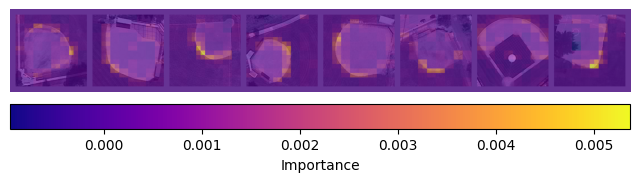

In [24]:
helpers.plotting.visualise_importance(base_exp.input.numpy(force=True), base_exp.explanation, alpha=0.6, with_colorbar=True)

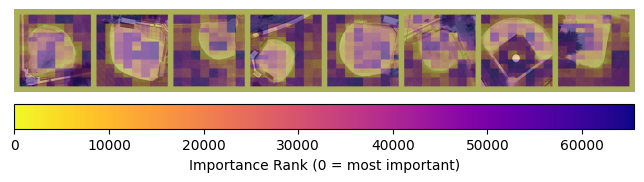

In [25]:
helpers.plotting.visualise_importance(base_exp.input.numpy(force=True), base_exp.ranked_explanation, alpha=0.4, with_colorbar=True)

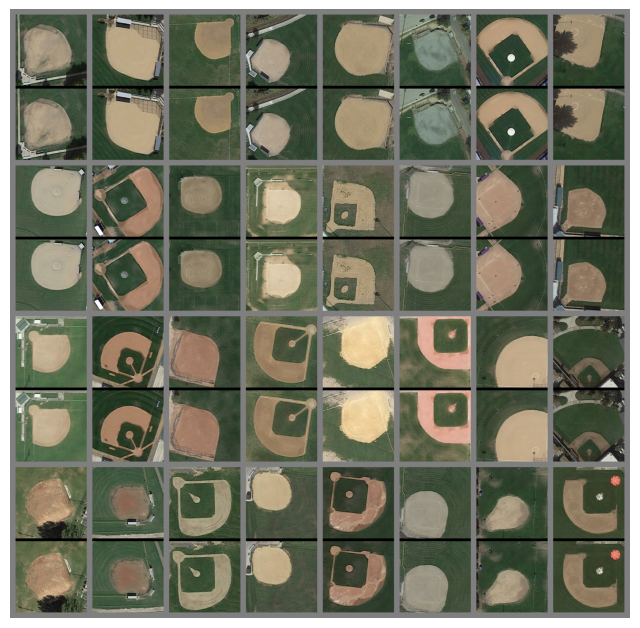

In [26]:
img_dict = np.load(helpers.env_var.get_xai_output_root() /
                   Path(dataset_name) / f"c{class_idx:02}" / "combined" /
                   f"{model_name}_adversarial_examples.npz")
og_imgs = img_dict["original_imgs"]
adv_imgs = img_dict["clipped_adv_imgs"]
helpers.plotting.show_image(
    np.stack([np.hstack([im1, -np.ones((3, 10, im1.shape[-1])), im2]) for im1, im2 in zip(og_imgs, adv_imgs)]),
    padding=20,
)

Adversarial images really are indistinguishable...

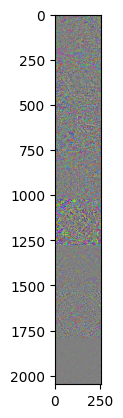

In [27]:
plt.imshow(np.hstack(og_imgs[:8] - adv_imgs[:8]).transpose(1,2,0)*50 + 1/2)

In [28]:
base_exp.model(torch.from_numpy(og_imgs).to(torch_device)).argmax(1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [29]:
base_exp.model(torch.from_numpy(adv_imgs).to(torch_device)).argmax(1)

tensor([ 1,  1, 16, 12,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1, 12,  1, 13, 37,
         1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1, 16,  1],
       device='cuda:0')

## Compare generated explanations visually

### Helpers functions

In [30]:
def compare_explanations(dataset_n, model_n, class_i, batch_n, use_ranked=True):
    ds, m = get_dataset_and_model(dataset_n, model_n)
    print(ds.classes[class_i])
    exp_list = []
    for en in t.get_args(xai.EXPLAINER_NAMES):
        exp = xai.get_explainer_object(
            en, m, extra_path=Path(dataset_n) / f"c{class_i:02}" / f"b{batch_n:03}",
        )
        exp.force_load()
        exp_list.append(exp)

    helpers.plotting.visualise_importance(
        np.concatenate([exp.input.numpy(force=True)[:8] for exp in exp_list]),
        np.concatenate(
            [exp.ranked_explanation[:8] if use_ranked else exp.explanation[:8] for exp in exp_list]
        ),
        alpha=0.5, with_colorbar=True
    )
    return exp_list

In [31]:
def compare_models(dataset_n, class_i, batch_n):
    for mn in AVAILABLE_MODELS:
        exp_list = compare_explanations(dataset_n, mn, class_i, batch_n)
        plt.title(mn)
        plt.show()
    return exp_list

In [32]:
def get_ds_classes(dataset_n):
    ds, _ = get_dataset_and_model(dataset_n, "ResNet50")
    return list(enumerate(ds.classes))

### UCMerced

In [33]:
dataset_name = "UCMerced"
batch_num = 0
print(get_ds_classes(dataset_name))

[(0, 'agricultural'), (1, 'airplane'), (2, 'baseballdiamond'), (3, 'beach'), (4, 'buildings'), (5, 'chaparral'), (6, 'denseresidential'), (7, 'forest'), (8, 'freeway'), (9, 'golfcourse'), (10, 'harbor'), (11, 'intersection'), (12, 'mediumresidential'), (13, 'mobilehomepark'), (14, 'overpass'), (15, 'parkinglot'), (16, 'river'), (17, 'runway'), (18, 'sparseresidential'), (19, 'storagetanks'), (20, 'tenniscourt')]


airplane


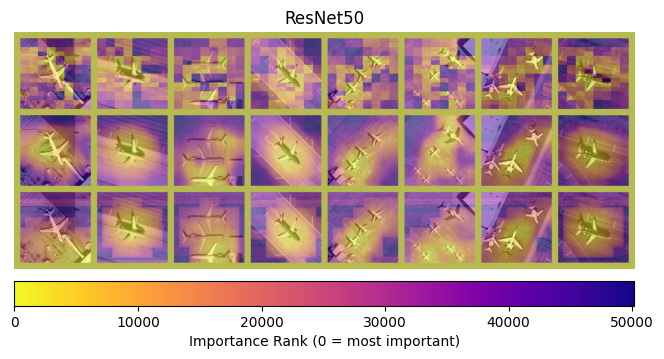

airplane


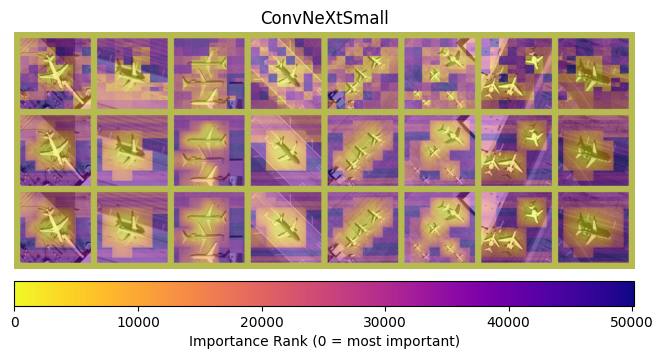

airplane


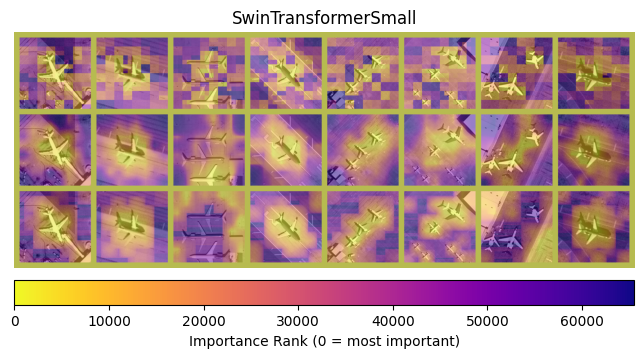

In [34]:
_ = compare_models(dataset_name, 1, batch_num)

Line artifacts indicate the rest of the image was deemed as not important/0 (see below)

airplane


[PartitionSHAP(model=ConvNeXtSmall, input_shape=torch.Size([16, 3, 224, 224]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/UCMerced/c01/b000/PartitionSHAP'),
 GradCAM(model=ConvNeXtSmall, input_shape=torch.Size([16, 3, 224, 224]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/UCMerced/c01/b000/GradCAM'),
 KPCACAM(model=ConvNeXtSmall, input_shape=torch.Size([16, 3, 224, 224]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/UCMerced/c01/b000/KPCACAM')]

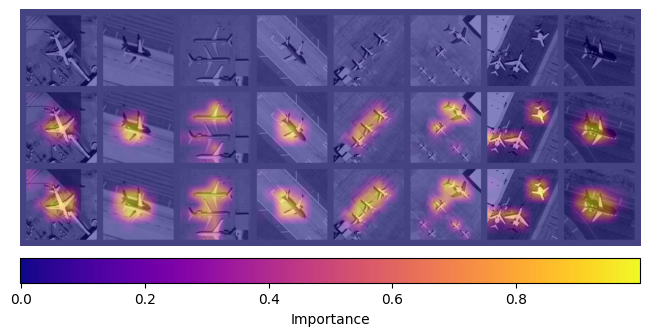

In [35]:
compare_explanations(dataset_name, "ConvNeXtSmall", 1, batch_num, use_ranked=False)

airplane


[PartitionSHAP(model=SwinTransformerSmall, input_shape=torch.Size([8, 3, 256, 256]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/UCMerced/c01/b000/PartitionSHAP'),
 GradCAM(model=SwinTransformerSmall, input_shape=torch.Size([8, 3, 256, 256]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/UCMerced/c01/b000/GradCAM'),
 KPCACAM(model=SwinTransformerSmall, input_shape=torch.Size([8, 3, 256, 256]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/UCMerced/c01/b000/KPCACAM')]

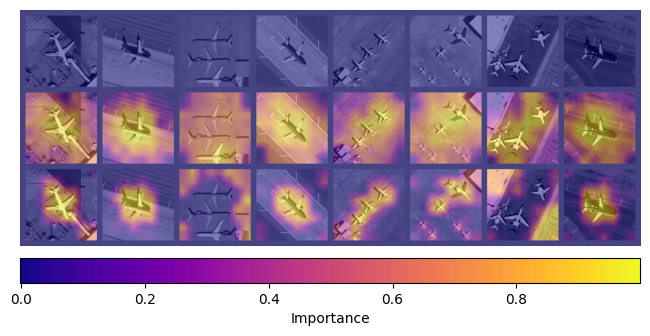

In [36]:
compare_explanations(dataset_name, "SwinTransformerSmall", 1, batch_num, use_ranked=False)

KPCA does some weird things for certain Swin Transformer images - reverse localisation.
Other explanation methods still highlight expected regions

So we expect the output-completeness and incremental deletion metrics to be worse for KPCA on SwinT

#### Investigate poor SwinT performance

In [290]:
CoIs = ("COR : incremental", "O-C")

In [291]:
ucm_airplane = xai_ds_m_c_df.loc[:, "UCMerced", :, "airplane"]
ucm_airplane

COR : random_sim : SR  \
xAI_method    model                                         
PartitionSHAP ConvNeXtSmall                    -0.01860     
              ResNet50                          0.14540     
              SwinTransformerSmall             -0.01530     
GradCAM       ConvNeXtSmall                     0.08965     
              ResNet50                          0.21150     
              SwinTransformerSmall              0.01781     
KPCACAM       ConvNeXtSmall                     0.16070     
              ResNet50                          0.28296     
              SwinTransformerSmall             -0.00707     

                                    COR : random_sim : top_m  \
xAI_method    model                                            
PartitionSHAP ConvNeXtSmall                     0.15302        
              ResNet50                          0.25030        
              SwinTransformerSmall              0.16273        
GradCAM       ConvNeXtSmall                     0.14261        
              ResNet50                          0.25832        
              SwinTransformerSmall              0.09734        
KPCACAM       ConvNeXtSmall                     0.14457        
              ResNet50                          0.24142        
              SwinTransformerSmall              0.09243        

                                    COR : random_sim : ssim  \
xAI_method    model                                           
PartitionSHAP ConvNeXtSmall                     0.40151       
              ResNet50                          0.44242       
              SwinTransformerSmall              0.44807       
GradCAM       ConvNeXtSmall                     0.31382       
              ResNet50                          0.38294       
              SwinTransformerSmall              0.38257       
KPCACAM       ConvNeXtSmall                     0.36224       
              ResNet50                          0.38643       
              SwinTransformerSmall              0.33141       

                                    COR : incremental_deletion_auc_ratio  \
xAI_method    model                                                        
PartitionSHAP ConvNeXtSmall                     0.36164                    
              ResNet50                          0.53012                    
              SwinTransformerSmall              0.29997                    
GradCAM       ConvNeXtSmall                     0.38759                    
              ResNet50                          0.57372                    
              SwinTransformerSmall              0.35316                    
KPCACAM       ConvNeXtSmall                     0.34379                    
              ResNet50                          0.78682                    
              SwinTransformerSmall              0.67091                    

                                    O-C : deletion_check_conf_drop  \
xAI_method    model                                                  
PartitionSHAP ConvNeXtSmall                     0.46616              
              ResNet50                          0.50657              
              SwinTransformerSmall              0.51761              
GradCAM       ConvNeXtSmall                     0.55041              
              ResNet50                          0.41139              
              SwinTransformerSmall              0.42845              
KPCACAM       ConvNeXtSmall                     0.56235              
              ResNet50                          0.29978              
              SwinTransformerSmall              0.23967              

                                    O-C : preservation_check_conf_drop  \
xAI_method    model                                                      
PartitionSHAP ConvNeXtSmall                     0.90047                  
              ResNet50                          0.72214                  
              SwinTransformerSmall              0.32402      

In [292]:
column_mask = [c for c in ucm_airplane.columns if c.startswith(CoIs)]
ucm_airplane[column_mask]

COR : incremental_deletion_auc_ratio  \
xAI_method    model                                                        
PartitionSHAP ConvNeXtSmall                     0.36164                    
              ResNet50                          0.53012                    
              SwinTransformerSmall              0.29997                    
GradCAM       ConvNeXtSmall                     0.38759                    
              ResNet50                          0.57372                    
              SwinTransformerSmall              0.35316                    
KPCACAM       ConvNeXtSmall                     0.34379                    
              ResNet50                          0.78682                    
              SwinTransformerSmall              0.67091                    

                                    O-C : deletion_check_conf_drop  \
xAI_method    model                                                  
PartitionSHAP ConvNeXtSmall                     0.46616              
              ResNet50                          0.50657              
              SwinTransformerSmall              0.51761              
GradCAM       ConvNeXtSmall                     0.55041              
              ResNet50                          0.41139              
              SwinTransformerSmall              0.42845              
KPCACAM       ConvNeXtSmall                     0.56235              
              ResNet50                          0.29978              
              SwinTransformerSmall              0.23967              

                                    O-C : preservation_check_conf_drop  
xAI_method    model                                                     
PartitionSHAP ConvNeXtSmall                     0.90047                 
              ResNet50                          0.72214                 
              SwinTransformerSmall              0.32402                 
GradCAM       ConvNeXtSmall                     0.90370                 
              ResNet50                          0.55817                 
              SwinTransformerSmall              0.29902                 
KPCACAM       ConvNeXtSmall                     0.89426                 
              ResNet50                          0.39627                 
              SwinTransformerSmall             -0.20274

The best score for a deletion/preservation check is 1/-1. This only appears to be successful for ConvNeXt for KPCACAM.

GradCAM does a similarity poor job for all except ConvNeXt.

ConvNeXtSmall           Axes(0.1,0.15;0....
ResNet50                Axes(0.382353,0....
SwinTransformerSmall    Axes(0.664706,0....
dtype: object

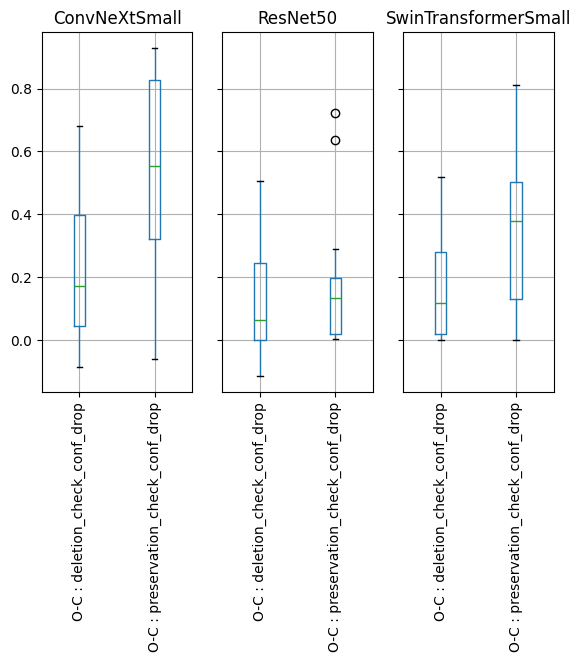

In [304]:
xai_ds_m_c_df[column_mask[1:]].loc["PartitionSHAP", dataset_name].groupby("model").boxplot(rot=90, sharey=True, layout=(1, 3), subplots=True)

KPCACAM is much more inconsistent than GradCAM. PartitionSHAP appears most reliable but still rarely over 0.5.

GradCAM          Axes(0.1,0.15;0....
KPCACAM          Axes(0.382353,0....
PartitionSHAP    Axes(0.664706,0....
dtype: object

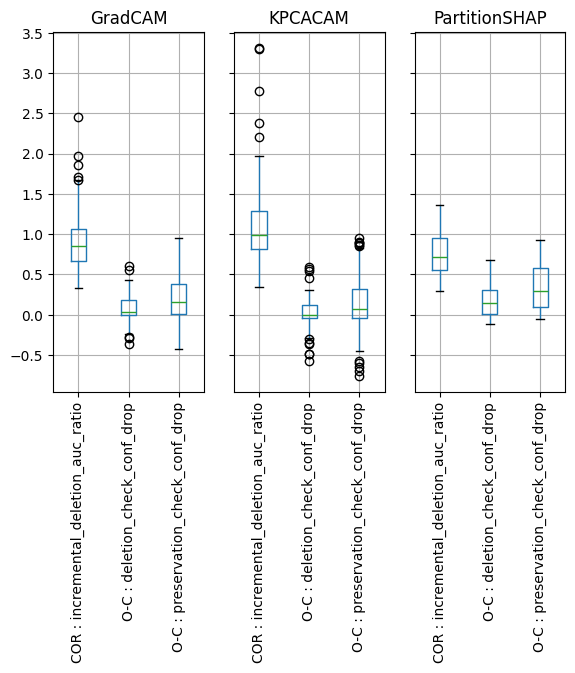

In [332]:
xai_ds_m_c_df[column_mask].loc[:, dataset_name, :].groupby("xai_method").boxplot(rot=90, subplots=True, layout=(1, 3))

<Axes: >

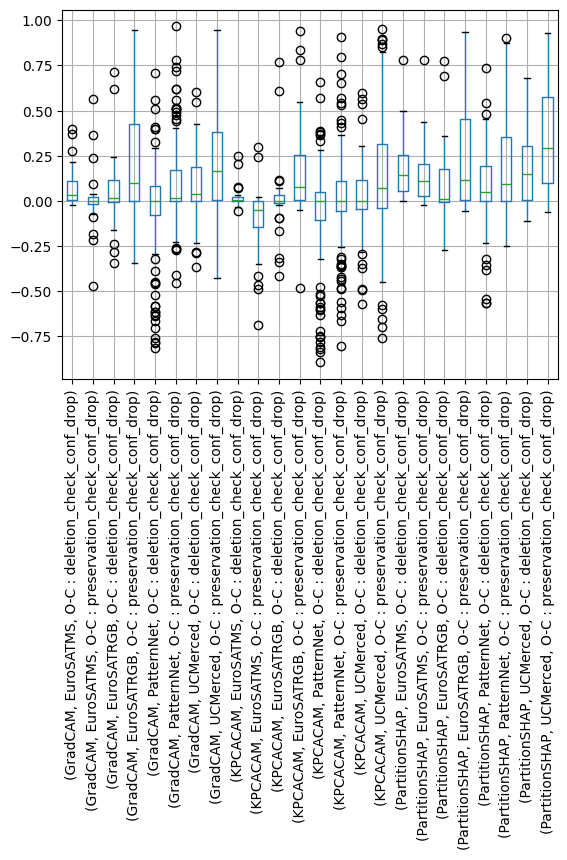

In [356]:
xai_ds_m_c_df[column_mask[1:]].groupby(level=["xai_method", "dataset"]).boxplot(rot=90, subplots=False)

### Inspect performance on more targetable land cover classes (not objects)

river


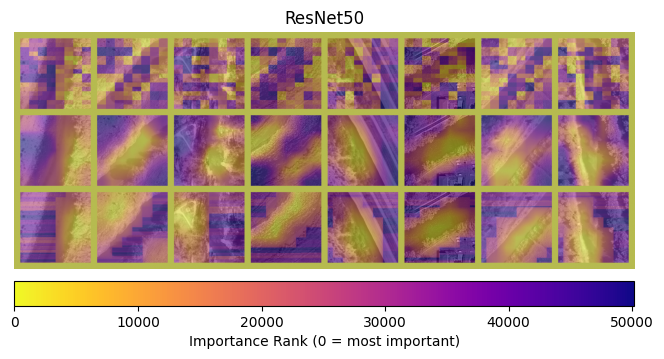

river


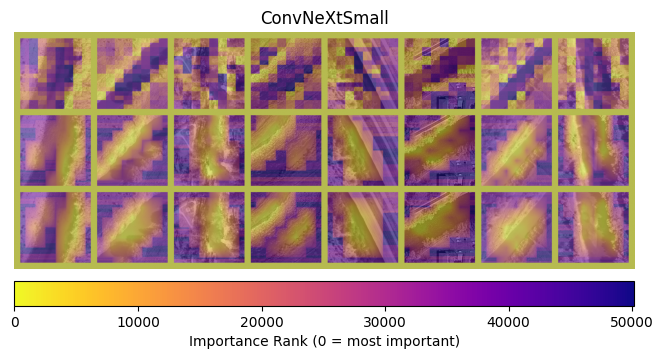

river


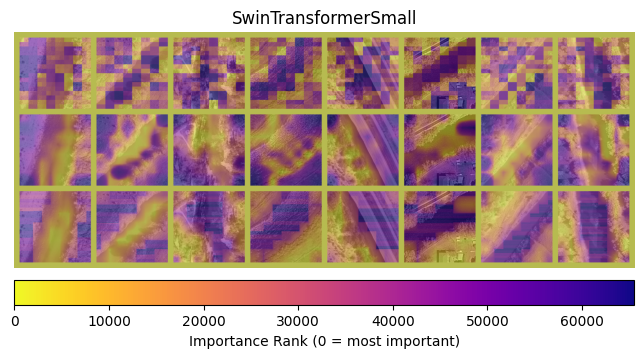

In [48]:
compare_models(dataset_name, 16, batch_num)

SHAP explanations get much messier for land based concepts - not as cohesive as GradCAM methods

But might be true to underlying model/unfair because of similar concepts

### EuroSATRGB

In [73]:
dataset_name = "EuroSATRGB"
get_ds_classes(dataset_name)

[(0, 'AnnualCrop'),
 (1, 'Forest'),
 (2, 'HerbaceousVegetation'),
 (3, 'Highway'),
 (4, 'Industrial'),
 (5, 'Pasture'),
 (6, 'PermanentCrop'),
 (7, 'Residential'),
 (8, 'River'),
 (9, 'SeaLake')]

#### AnnualCrop

AnnualCrop


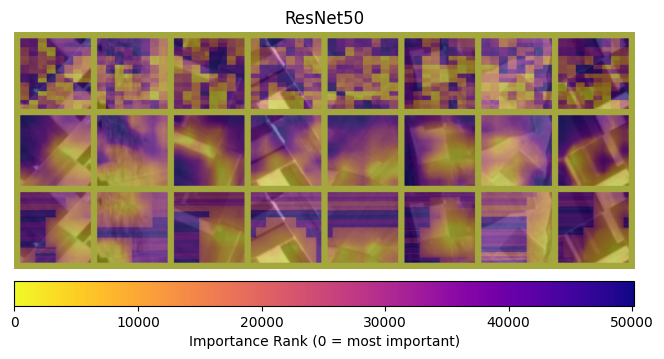

AnnualCrop


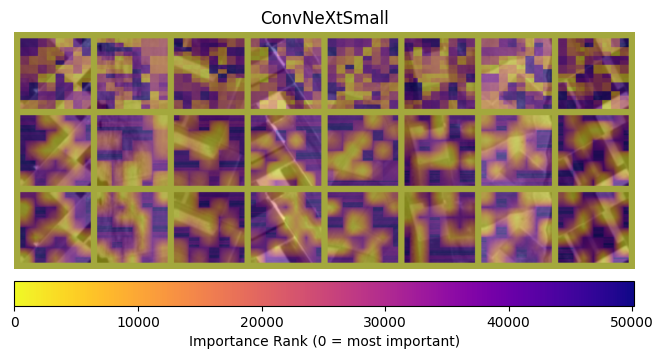

AnnualCrop


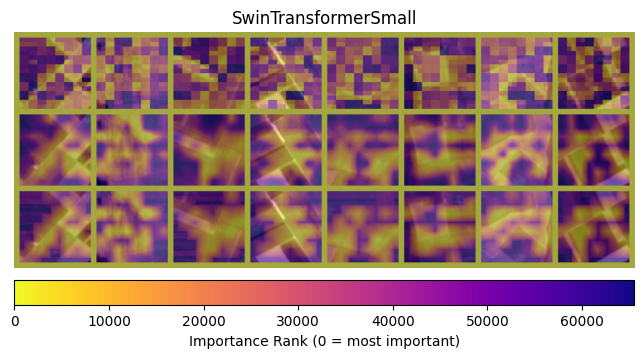

[PartitionSHAP(model=SwinTransformerSmall, input_shape=torch.Size([8, 3, 256, 256]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/EuroSATRGB/c00/b000/PartitionSHAP'),
 GradCAM(model=SwinTransformerSmall, input_shape=torch.Size([8, 3, 256, 256]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/EuroSATRGB/c00/b000/GradCAM'),
 KPCACAM(model=SwinTransformerSmall, input_shape=torch.Size([8, 3, 256, 256]), has_explanation=True, save_path='/home2/jgcw74/l3_project/xai_output_unix/EuroSATRGB/c00/b000/KPCACAM')]

In [74]:
last_exp_list = compare_models(dataset_name, 0, batch_num)
last_exp_list

Explanations are much less localised with EuroSAT for a general area class such as AnnualCrop

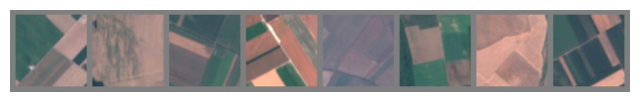

In [76]:
helpers.plotting.show_image(last_exp_list[-1].input[:8], padding=20)

#### Highways and rivers

River


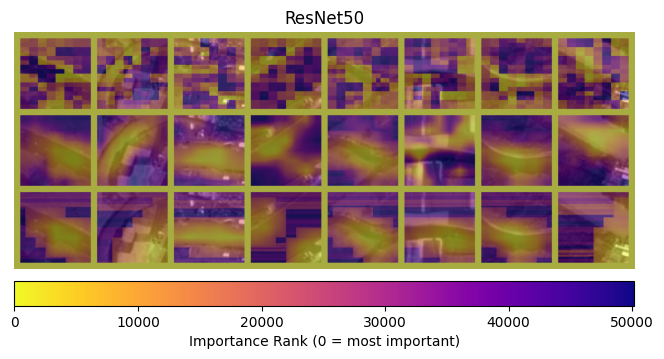

River


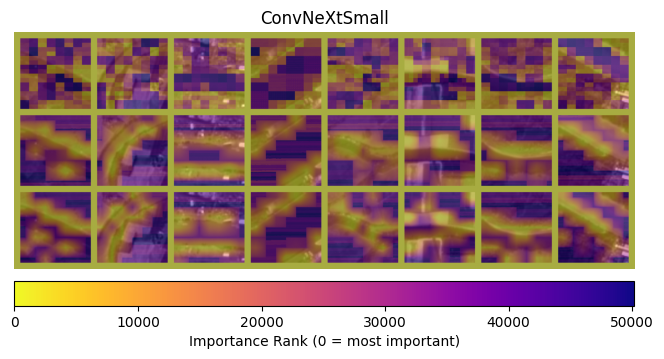

River


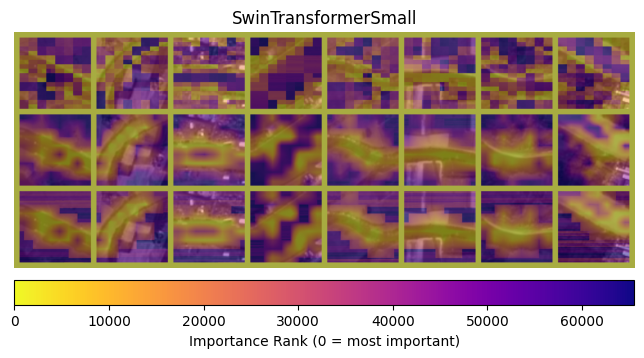

In [77]:
last_exp_list = compare_models(dataset_name, 8, batch_num)

Rivers are easier - all appear to learn the banks of the river

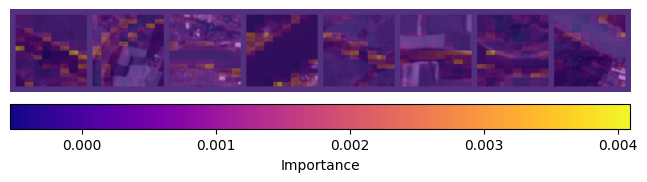

In [79]:
helpers.plotting.visualise_importance(last_exp_list[0].input, last_exp_list[0].explanation, alpha=0.5)

Raw SHAP explanations much more precise and localised

Highway


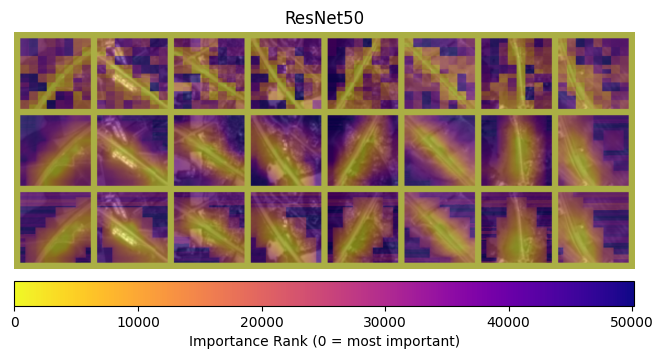

Highway


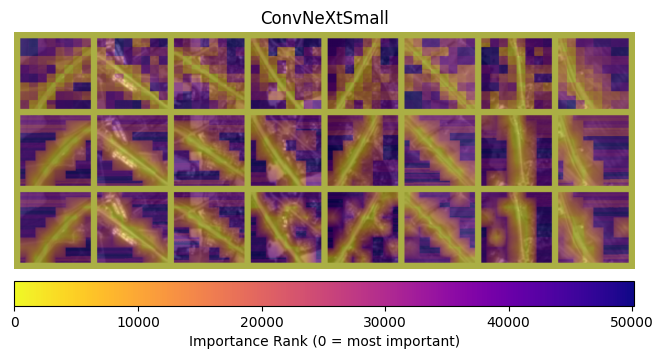

Highway


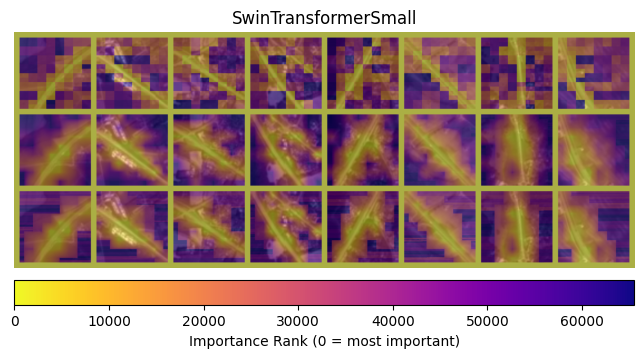

In [80]:
last_exp_list = compare_models(dataset_name, 3, batch_num)

## Compare RGB and MS efficacy

## Plot evaluation results

In [14]:
explainer_name = "PartitionSHAP"
dataset_name = "EuroSATRGB"
model_name = "ConvNeXtSmall"

In [15]:
dfs[explainer_name][f"{dataset_name}_{model_name}"]

correctness : randomised_model_similarity : l2_distance  \
AnnualCrop                                                     0.000309         
Forest                                                         0.001170         
HerbaceousVegetation                                           0.000680         
Highway                                                        0.001930         
Industrial                                                     0.001106         
Pasture                                                        0.000456         
PermanentCrop                                                  0.000864         
Residential                                                    0.001449         
River                                                          0.000894         
SeaLake                                                        0.001489         

                      correctness : randomised_model_similarity : spearman_rank  \
AnnualCrop                                                     0.020391           
Forest                                                        -0.011114           
HerbaceousVegetation                                           0.103787           
Highway                                                       -0.014775           
Industrial                                                    -0.008049           
Pasture                                                        0.079362           
PermanentCrop                                                  0.040660           
Residential                                                   -0.002699           
River                                                         -0.090042           
SeaLake                                                        0.026759           

                      correctness : randomised_model_similarity : top_k_intersection  \
AnnualCrop                                                     0.180779                
Forest                                                         0.099088                
HerbaceousVegetation                                           0.154469                
Highway                                                        0.136330                
Industrial                                                     0.116479                
Pasture                                                        0.115626                
PermanentCrop                                                  0.143151                
Residential                                                    0.115158                
River                                                          0.148314                
SeaLake                                                        0.115190                

                      correctness : randomised_model_similarity : structural_similarity  \
AnnualCrop                                                     0.408234                   
Forest                                                         0.389683                   
HerbaceousVegetation                                           0.416697                   
Highway                                                        0.412067                   
Industrial                                                     0.397792                   
Pasture                                                        0.396949                   
PermanentCrop                                                  0.392772                   
Residential                                                    0.386002                   
River                                                          0.383533                   
SeaLake                                                        0.428047                   

                      correctness : incremental_deletion_auc_ratio  \
AnnualCrop                                                1.522604   
Forest                                                    0.997463   
HerbaceousVegetation               